In [1]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# !pip install keras
# !pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [2]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



08-10-2017
just added:  ethereum


,ethereum,ethereum_volume
date,,
2017-08-10,306.826433,4.116430e+08
2017-08-11,308.625531,4.854745e+08
2017-08-12,297.159803,6.890798e+08
2017-08-13,296.397290,3.844787e+08
2017-08-14,288.450767,5.269512e+08
...,...,...
2022-08-05,1725.382627,1.771748e+10
2022-08-06,1693.296592,1.123110e+10
2022-08-07,1699.006418,9.464716e+09


In [3]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [4]:
my_data = mydf
# display(my_data.tail(10))
# my_data.drop(my_data.tail(10).index,
#         inplace = True)
display(my_data)

,ethereum,ethereum_volume
date,,
2017-08-10,306.826433,4.116430e+08
2017-08-11,308.625531,4.854745e+08
2017-08-12,297.159803,6.890798e+08
2017-08-13,296.397290,3.844787e+08
2017-08-14,288.450767,5.269512e+08
...,...,...
2022-08-05,1725.382627,1.771748e+10
2022-08-06,1693.296592,1.123110e+10
2022-08-07,1699.006418,9.464716e+09


### The start of LSTM

Train Test Split

In [5]:
seq=list(mydf['ethereum'])
# display(seq)
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))
window_size = 15
my_target = window_size-1
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[11,12,13])
display(sliding_df)

dataset = sliding_df

# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(dataset.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

,0,1,2,3,4,5,6,7,8,9,10,14
0,306.826433,308.625531,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,329.025281
1,308.625531,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,329.865783
2,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,343.341337
3,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,344.201131
4,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,366.809590
...,...,...,...,...,...,...,...,...,...,...,...,...
1807,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556,1725.382627
1808,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1693.296592
1809,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1699.006418
1810,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1775.701356


(1448, 12)
(364, 12)


In [6]:
# close_prices = stock_data['Close']
# values = close_prices.values
values = mydf['ethereum'].values
# print(values)
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train)
print(y_train)

[[[0.04714229]
  [0.04752255]
  [0.04509913]
  ...
  [0.04772814]
  [0.04719126]
  [0.04483308]]

 [[0.04752255]
  [0.04509913]
  [0.04493796]
  ...
  [0.04719126]
  [0.04483308]
  [0.0456819 ]]

 [[0.04509913]
  [0.04493796]
  [0.04325837]
  ...
  [0.04483308]
  [0.0456819 ]
  [0.04638583]]

 ...

 [[0.51661876]
  [0.53619154]
  [0.50786368]
  ...
  [0.5581535 ]
  [0.57868045]
  [0.59285916]]

 [[0.53619154]
  [0.50786368]
  [0.48039395]
  ...
  [0.57868045]
  [0.59285916]
  [0.64833857]]

 [[0.50786368]
  [0.48039395]
  [0.48533072]
  ...
  [0.59285916]
  [0.64833857]
  [0.61897849]]]
[0.0456819  0.04638583 0.04612639 ... 0.64833857 0.61897849 0.65084261]


In [7]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)

[[[0.48039395]
  [0.48533072]
  [0.51445217]
  ...
  [0.64833857]
  [0.61897849]
  [0.65084261]]

 [[0.48533072]
  [0.51445217]
  [0.52916507]
  ...
  [0.61897849]
  [0.65084261]
  [0.64762533]]

 [[0.51445217]
  [0.52916507]
  [0.5236288 ]
  ...
  [0.65084261]
  [0.64762533]
  [0.65159982]]

 ...

 [[0.36158837]
  [0.36029455]
  [0.33396436]
  ...
  [0.32309497]
  [0.34697121]
  [0.34018944]]

 [[0.36029455]
  [0.33396436]
  [0.3056829 ]
  ...
  [0.34697121]
  [0.34018944]
  [0.34139628]]

 [[0.33396436]
  [0.3056829 ]
  [0.28975638]
  ...
  [0.34018944]
  [0.34139628]
  [0.35760668]]]


In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1401/1401 [==============================] - 26s 16ms/step - loss: 0.0031
Epoch 2/3
1401/1401 [==============================] - 23s 17ms/step - loss: 7.4364e-04
Epoch 3/3
1401/1401 [==============================] - 25s 18ms/step - loss: 8.2753e-04


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

12/12 [==============================] - 1s 21ms/step


65.4535964447408

C:\Users\fooba\AppData\Local\Temp/ipykernel_30216/1818427519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


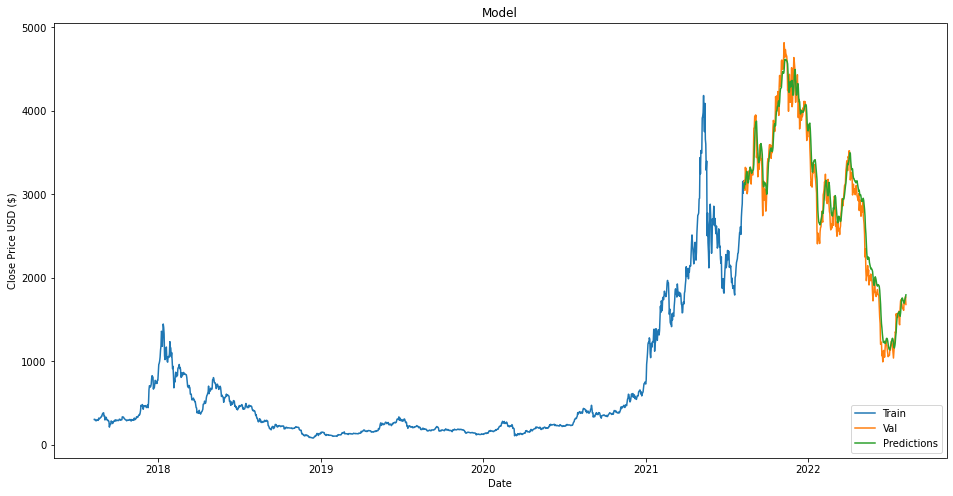

In [11]:
data = mydf.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

C:\Users\fooba\AppData\Local\Temp/ipykernel_30216/23900057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


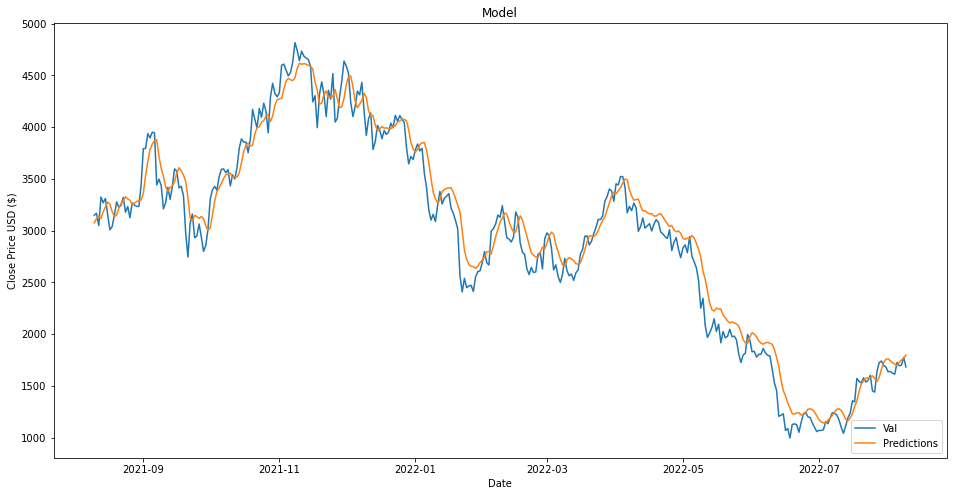

In [12]:
data = mydf.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [13]:
# buy when prediction is below price, and sell when prediction is above price

# validation['buy'] = if validation['ethereum'] > validation['Predictions']


validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
display(validation)

C:\Users\fooba\AppData\Local\Temp/ipykernel_30216/3091847555.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
C:\Users\fooba\AppData\Local\Temp/ipykernel_30216/3091847555.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)


,ethereum,Predictions,buy,sell
date,,,,
2021-08-10,3147.842995,3075.526611,1,0
2021-08-11,3166.647218,3114.640381,1,0
2021-08-12,3048.412682,3139.959717,0,1
2021-08-13,3323.197991,3118.055176,1,0
2021-08-14,3268.548177,3180.338623,1,0
...,...,...,...,...
2022-08-05,1725.382627,1697.087036,1,0
2022-08-06,1693.296592,1726.518799,0,1
2022-08-07,1699.006418,1749.708862,0,1


In [14]:
# !pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

C:\Users\fooba\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Row(id='1450', ...)

In [15]:
theD = pd.DataFrame(validation)
theD['Open'] = theD['ethereum']
theD['High'] = theD['ethereum']
theD['Low'] = theD['ethereum']
theD['Close'] = theD['ethereum']
theD = theD.drop(columns='ethereum')

display(theD)


,Predictions,buy,sell,Open,High,Low,Close
date,,,,,,,
2021-08-10,3075.526611,1,0,3147.842995,3147.842995,3147.842995,3147.842995
2021-08-11,3114.640381,1,0,3166.647218,3166.647218,3166.647218,3166.647218
2021-08-12,3139.959717,0,1,3048.412682,3048.412682,3048.412682,3048.412682
2021-08-13,3118.055176,1,0,3323.197991,3323.197991,3323.197991,3323.197991
2021-08-14,3180.338623,1,0,3268.548177,3268.548177,3268.548177,3268.548177
...,...,...,...,...,...,...,...
2022-08-05,1697.087036,1,0,1725.382627,1725.382627,1725.382627,1725.382627
2022-08-06,1726.518799,0,1,1693.296592,1693.296592,1693.296592,1693.296592
2022-08-07,1749.708862,0,1,1699.006418,1699.006418,1699.006418,1699.006418


In [16]:
# display(GOOG)


display(theD)
class LSTMCross(Strategy):
    def init(self):
        price = self.data.Close
        self.p = self.data.Close
        self.pred = self.data.Predictions

    def next(self):
        if crossover(self.pred, self.p):
            self.buy()
        elif crossover(self.p, self.pred):
            self.sell()


bt = Backtest(theD, LSTMCross, commission=.002,
              exclusive_orders=True)

stats = bt.run()
bt.plot()

,Predictions,buy,sell,Open,High,Low,Close
date,,,,,,,
2021-08-10,3075.526611,1,0,3147.842995,3147.842995,3147.842995,3147.842995
2021-08-11,3114.640381,1,0,3166.647218,3166.647218,3166.647218,3166.647218
2021-08-12,3139.959717,0,1,3048.412682,3048.412682,3048.412682,3048.412682
2021-08-13,3118.055176,1,0,3323.197991,3323.197991,3323.197991,3323.197991
2021-08-14,3180.338623,1,0,3268.548177,3268.548177,3268.548177,3268.548177
...,...,...,...,...,...,...,...
2022-08-05,1697.087036,1,0,1725.382627,1725.382627,1725.382627,1725.382627
2022-08-06,1726.518799,0,1,1693.296592,1693.296592,1693.296592,1693.296592
2022-08-07,1749.708862,0,1,1699.006418,1699.006418,1699.006418,1699.006418


Row(id='2083', ...)

In [17]:
# !pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.data.Open
        self.ma2 = self.data.Predictions

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(theD, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='2674', ...)